In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs

%matplotlib inline

# Review

## Time and Space Complexity ✨Vibes✨

### KNN
- How is a KNN model "trained"? Is this a faster or slower process than the other model's we've learned?
  - KNN doesn’t really have a training phase like most other models. “Training” just means storing the entire dataset so it can be used later for comparisons. This makes the training process much faster compared to models like decision trees or Naive Bayes, since there’s no actual model being built.
- What do I need to store to make a prediction with a trained KNN model? How would that change if I added a new *row*? How would that change if I added a new *predictor*?
  - You need to keep the entire training dataset because KNN predicts by calculating the distance between the new data point and all the existing ones. Then it looks at the k closest neighbors and picks the most common class among them.
  - You’d store that row with the rest of the data. It doesn’t change the prediction process, but it does make it slightly slower because there’s one more comparison to make.
  - You’d also store the new feature for every row. Prediction would get a little slower since distance calculations now involve more dimensions, and adding more features can sometimes make those comparisons less meaningful due to the curse of dimensionality.


### Naive Bayes
- How does a trained Naive Bayes model make a prediction?
  - It uses the probabilities learned during training. The model calculates the likelihood of each class based on the input features and then chooses the class with the highest probability. It assumes the features are independent, which keeps things simple and fast.
- Would adding a new *row* change how quickly I can make that prediction? What about adding a new *predictor*?
  - No, prediction time stays the same. The model already has the probabilities it needs, so a new row won’t affect that unless you retrain the model to include it.
  - Yes, but only slightly. The model has to do one more probability calculation per class, so predictions take a tiny bit longer, but it’s still very fast overall.
- Would adding a new *row* change how many values I need to store to make a prediction? What about adding a new *predictor*?
  - Not really, unless you retrain the model. If you do, you’ll need to update the counts used to calculate probabilities, which might take up a bit more space.
  - Yes, that changes things more. You’d need to store conditional probabilities for the new feature across all classes, so it increases the total amount of stored information.

## Naive Bayes
### Naive
Naive Bayes is **Naive** because it makes the assumption of **conditional independence**. This means that within classes (the groups we're trying to predict), we assume the predictors are *independent*. However we know that's not true, so it's a *Naive* assumption to make.

However, it simplifies our computation. When events are *independent* we can calculate their joint probability just by multiplying them:

$$\underbrace{P(A,B,C)}_\text{probability of A, B, and C} = P(A) * P(B) * P(C)$$

Rather than calculating the joint probability $P(A,B,C)$ by taking into account any relationships between the predictors.

### Bayes
When classifying a data point, we use Bayes' Theorem (at least the numerator of it) to calculate the *score* for each potential category. Then we choose the category with the highest score. Because we're comparing scores that have the same denominator, we can ignore it (which is nice, as it's difficiult to calculate).

$$ \overbrace{P(\text{group}_i | \mathbf{X}) = \frac{P(\mathbf{X} | \text{group}_i) * P(\text{group}_i)}{P(\mathbf{X})}}^\text{Bayes' Theorem}$$

- $P(\text{group}_i | \mathbf{X})$ is the probability of our data point being in group $i$ based on their predictor values $\mathbf{X}$
- $P(\mathbf{X} | \text{group}_i)$ is the likelihood of seeing features like $\mathbf{X}$ in group $i$ (if our features are commonly seen in group $i$, we're more likely to predict you're in group $i$)
- $P(\text{group}_i)$ is the probability of being in group $i$ overall (if a group is very rare, we don't want to predict it often)
- $P(\mathbf{X})$ is the probability of seeing features like $\mathbf{X}$ overall, in any group (but we ignore this term)

## Naive Bayes in `sklearn`

- `GaussianNB()`
- `BernoulliNB()`
- `CategoricalNB()`

In [2]:
bey = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/Beyonce_data.csv")
bey.head()


predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
nb = GaussianNB()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", nb)])

# fit
pipe.fit(X_train, y_train)

# predict

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1]
y_pred_test_prob = pipe.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.7783641160949868
Train Prescision:  0.7879656160458453
Train Recall    :  0.9649122807017544
Train F1        :  0.8675078864353313
Train ROC AUC   :  0.7253079507278835
Test Acc        :  0.7157894736842105
Test Prescision :  0.7272727272727273
Test Recall     :  0.9552238805970149
Test F1         :  0.8258064516129032
Test ROC AUC    :  0.6599147121535182


## KNN
KNN is a simple, distance based algorithm that let's us CLASSIFY data points based on what class the data points around them are.

Despite it being distance based, KNN is a *classification* algorithm. In other words, it is supervised machine learning, as it requires truth labels (the actual class/group). However it does share characteristics with clustering algorithms we will see later.

KNN *can* work with binary/categorical variables, but not without some tweaking which we do not cover here.

### Hyperparameters

Hyperparameters are parameters in our model that are NOT chosen by the algorithm (we must supply them). We can either choose them:

- based on domain expertise (knowledge about the data)
- based on the data (hyperparameter tuning)

Why do we have to use a validation set when hyperparameter tuning?


### Building a KNN Model

In [3]:
bey = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/Beyonce_data.csv")
bey.head()

# what K do I use??
predictors = ["energy", "danceability", "valence"]

X = bey[predictors]
y = bey["mode"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

# make pipeline
pipe = Pipeline([("pre", z), ("model", knn2)])

# choose potential values of k
ks = {"model__n_neighbors": [1,2,5,10,20]}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "precision", cv = 5, refit = True)

grid.fit(X_train, y_train)

print("GridSearchCV chose: ", grid.best_estimator_.get_params()["model__n_neighbors"])

# predict
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

y_pred_train_prob = grid.predict_proba(X_train)[:,1]
y_pred_test_prob = grid.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

GridSearchCV chose:  2
Train Acc       :  0.941952506596306
Train Prescision:  1.0
Train Recall    :  0.9197080291970803
Train F1        :  0.9581749049429658
Train ROC AUC   :  0.9881473757386166
Test Acc        :  0.8526315789473684
Test Prescision :  0.9705882352941176
Test Recall     :  0.8461538461538461
Test F1         :  0.9041095890410958
Test ROC AUC    :  0.8846153846153846



## KNN plotting

(this will only work with specific 2D data, if you wanted to use it for your own data you'd need to change the code to do so)

K-Nearest Neighbors is a straightforward algorithm: given a training set, classify a new (unknown) data point by counting the K nearest known points, and choosing the most common classification.

In this classwork we'll use ggplot to plot the boundaries of knn, and see how the size, shape, and overlap of clusters affect these boundries.

In [4]:
def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf[Xdf.columns[0]]) - np.std(Xdf[Xdf.columns[0]]),
                           max(Xdf[Xdf.columns[0]]) + np.std(Xdf[Xdf.columns[0]]), num = 100)
    x1_range = np.linspace(min(Xdf[Xdf.columns[1]]) - np.std(Xdf[Xdf.columns[1]]),
                           max(Xdf[Xdf.columns[1]]) + np.std(Xdf[Xdf.columns[1]]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({Xdf.columns[0]: x0, Xdf.columns[1]: x1})

    #build model

    knn = KNeighborsClassifier(n_neighbors = k)
    pipe = Pipeline([("model",knn)])

    pipe.fit(Xdf,y)

    # predict all background points
    p = pipe.predict(x_grid)
    x_grid["p"] = p #add to dataframe

    #build the plot
    bound = (ggplot(x_grid, aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_manual(name = "Class", values = ["#E69F00", "#0072B2"]) +
                 geom_point(data = Xdf, mapping = aes(x = Xdf.columns[0], y = Xdf.columns[1], color = "factor(y)"), size = 2))
    display(bound)

## Explore

Let's test this function with some fake data:

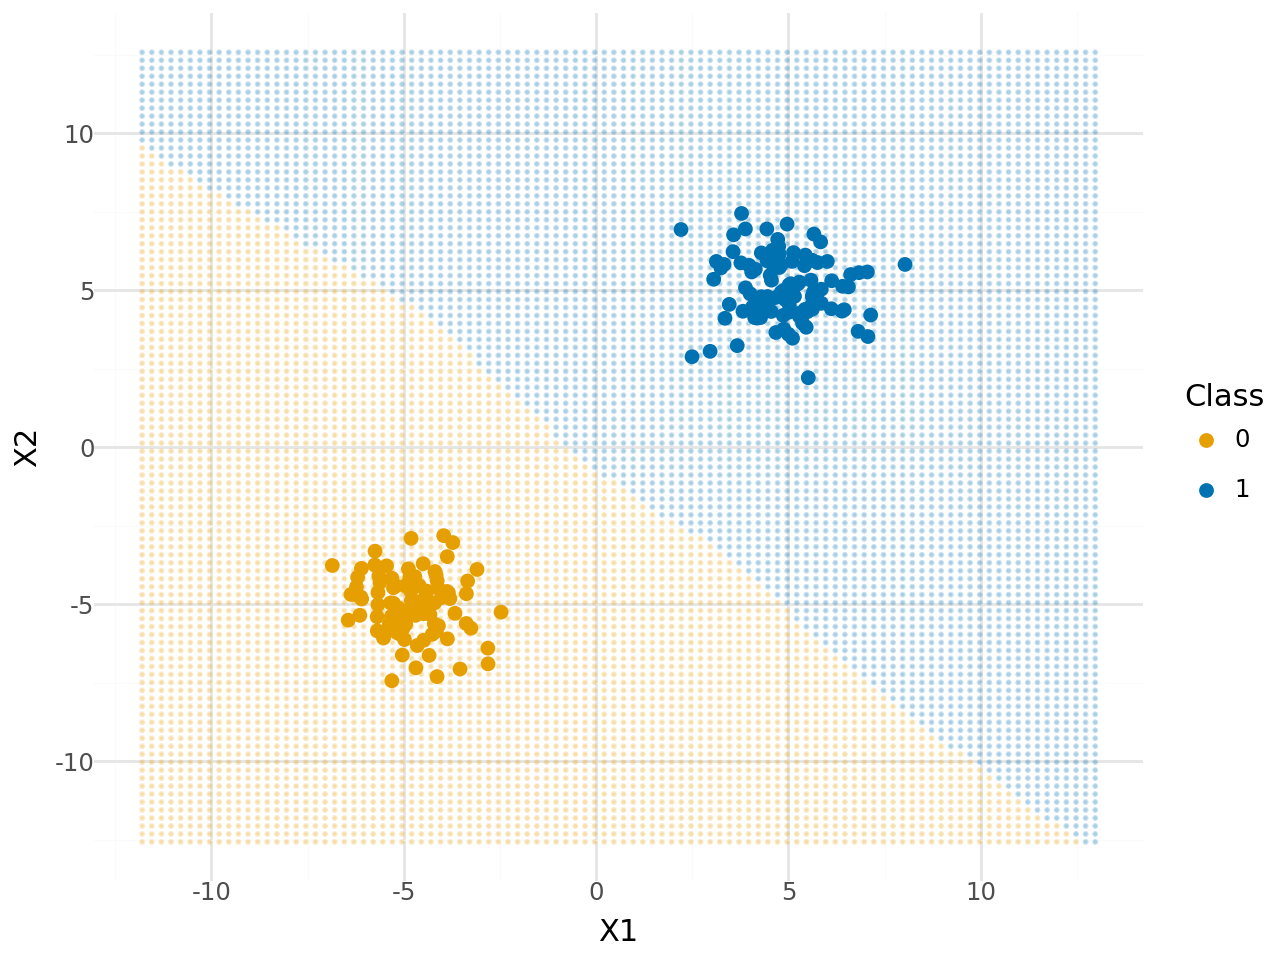

In [5]:
# Generate Fake Data
centers = [(-5, -5),
           (5, 5)]
cluster_std = [1, 1]
n = 200

X, y = make_blobs(n_samples=n, cluster_std=cluster_std,
                  centers=centers, n_features=2, random_state=1)

# make it into a dataframe for ggplot
X = pd.DataFrame(X)
X.columns = ["X1", "X2"] #rename cols so they're not ints

plotKNN2D(X,y,1)

## How does changing K affect the decision boundary?

Using the dataframe `dd` and using the `plotKNN2d()` function build KNN models with K = 1, 3, 5, 20, 50, 100.

**How does the decision boundary change as K changes?**
- The decision boundary becomes smoother and more defined as K increases.

In [6]:
dd = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/knnclasswork.csv")
dd.head()

X1        X2  y
0  -1.710595 -5.593345  0
1 -14.912877 -3.722297  0
2  -8.533054 -5.908033  0
3   6.188479 -3.813313  0
4  -6.062674 -3.809560  0

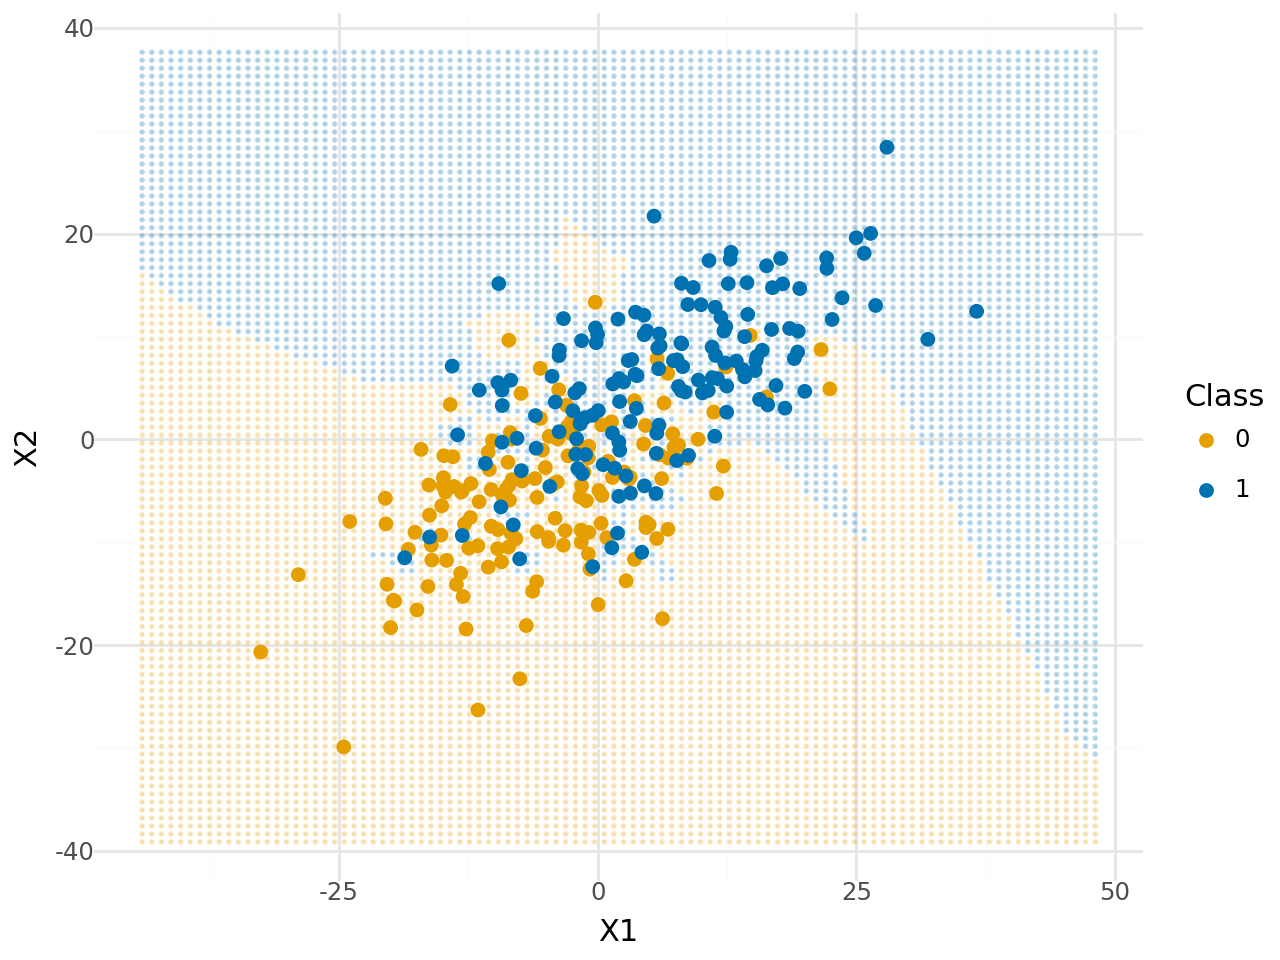

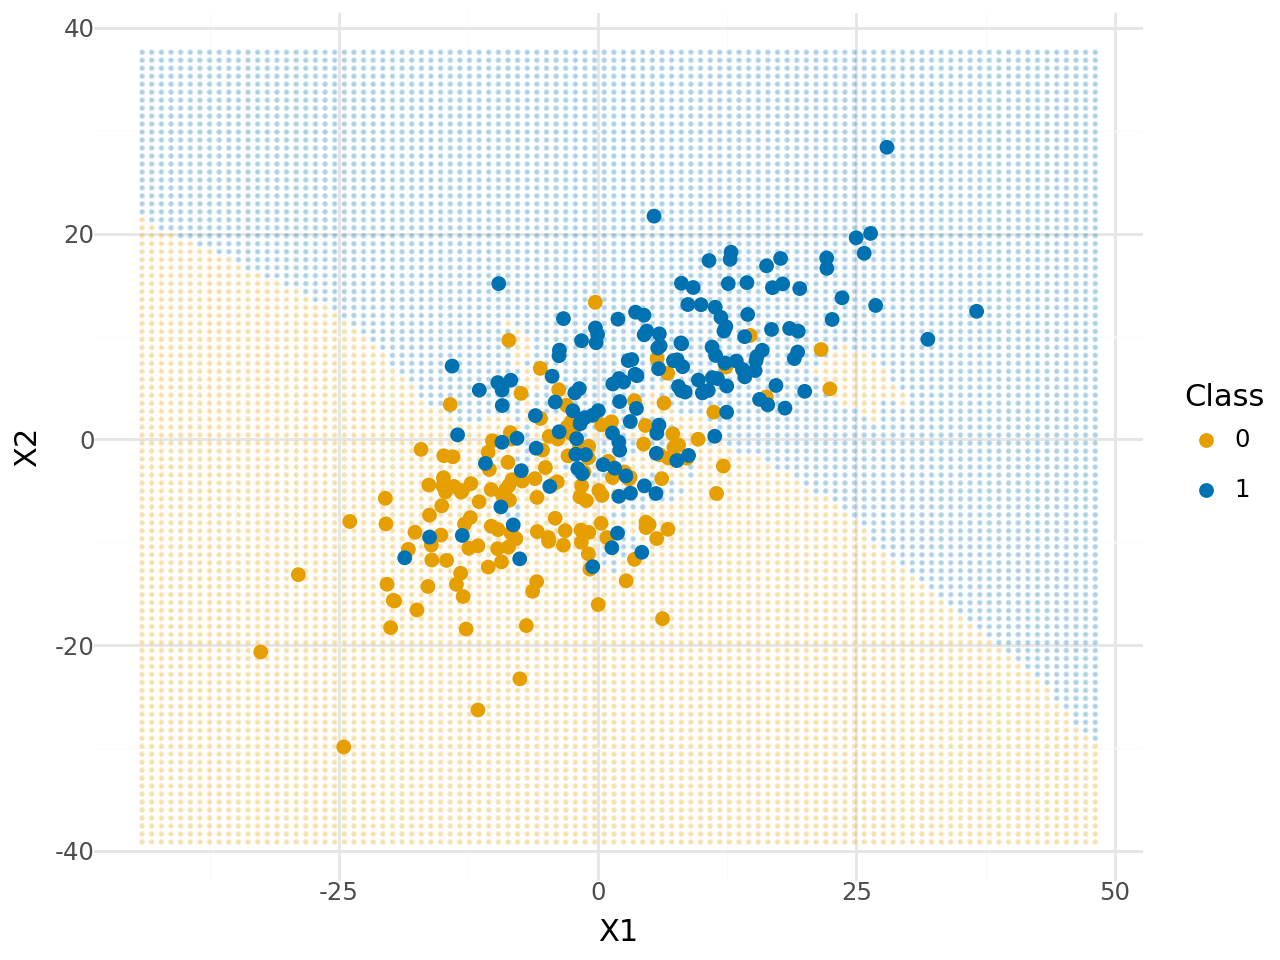

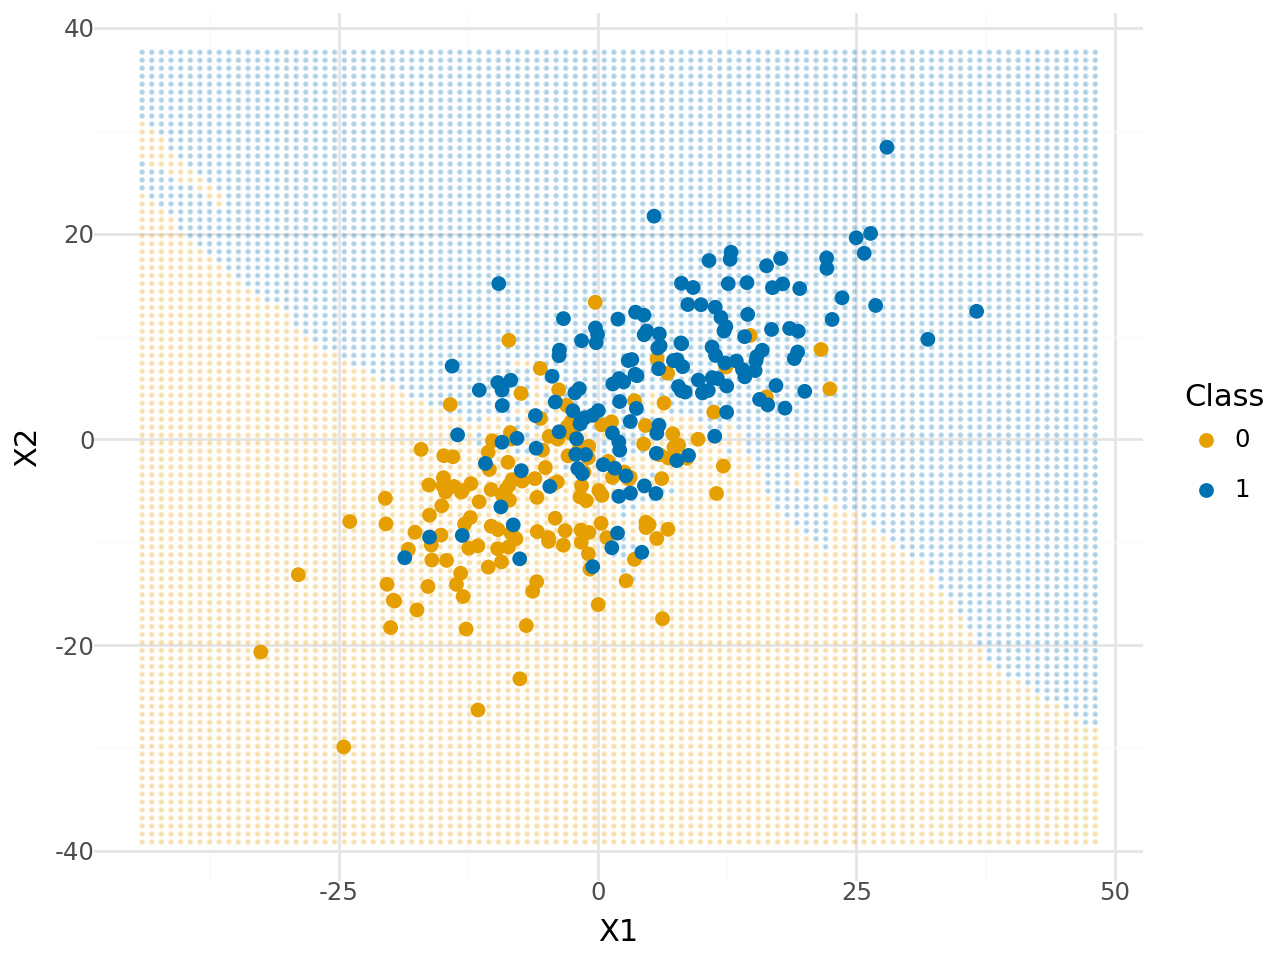

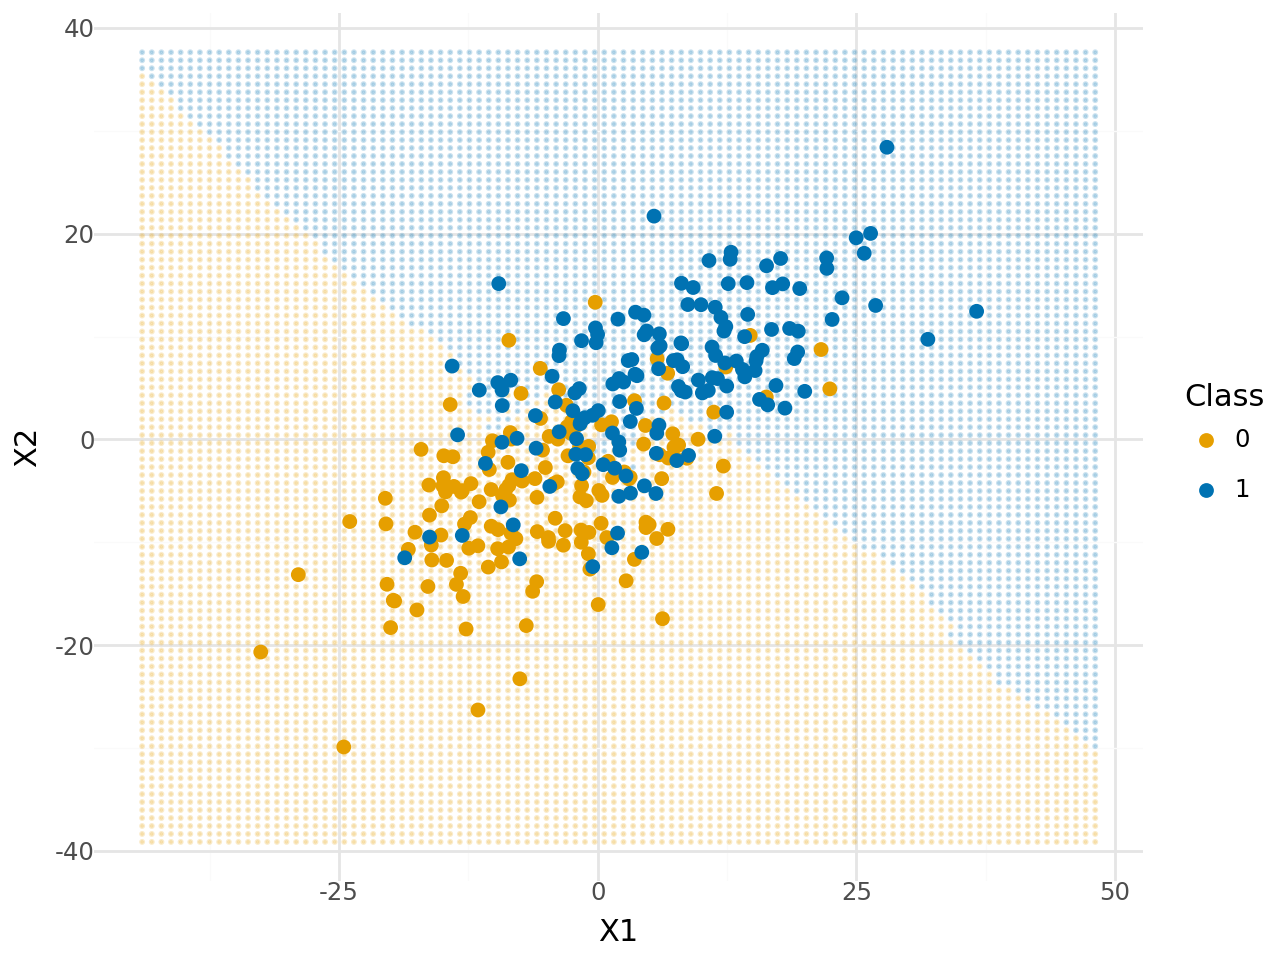

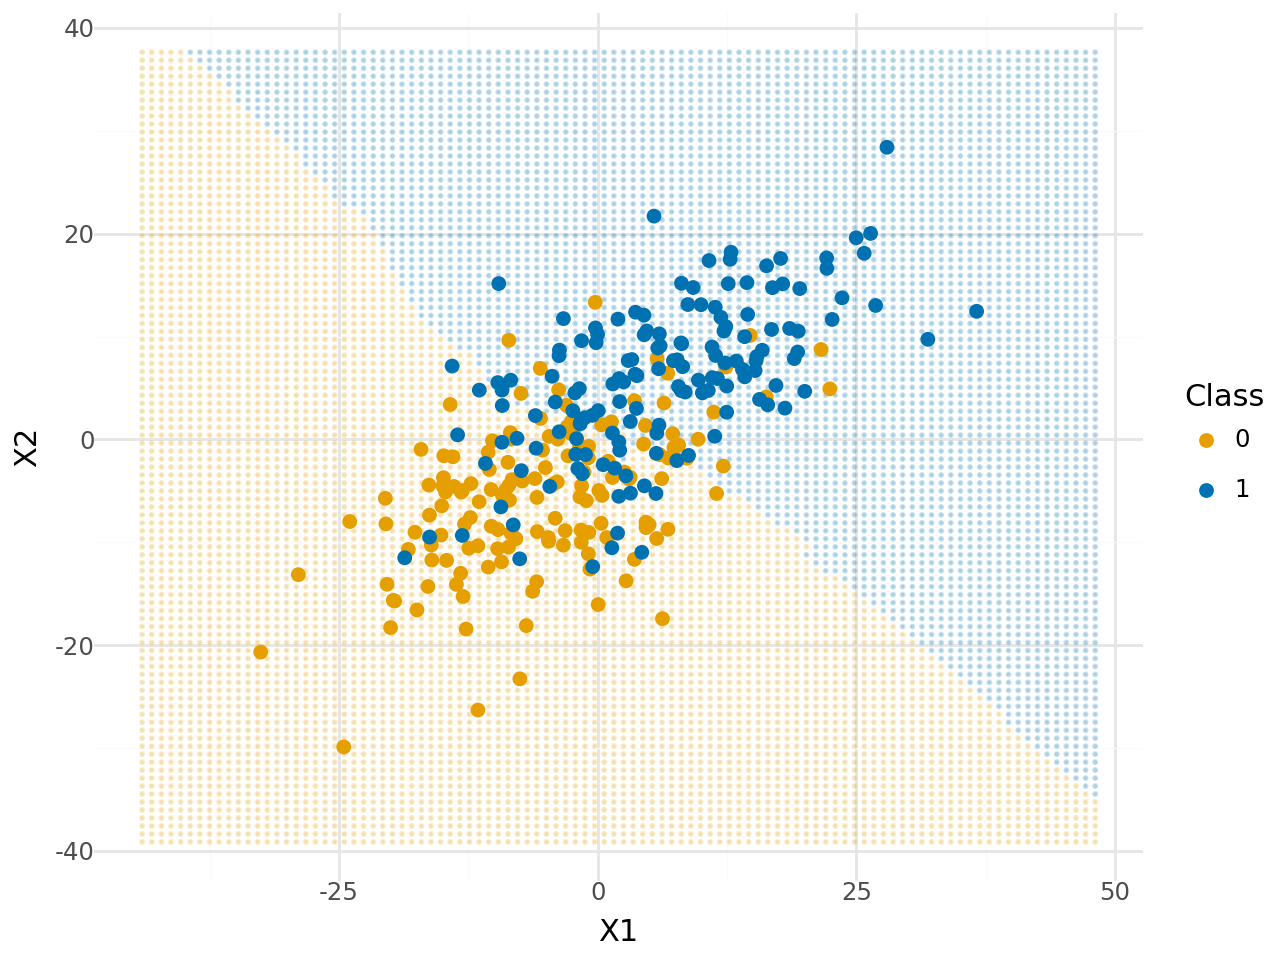

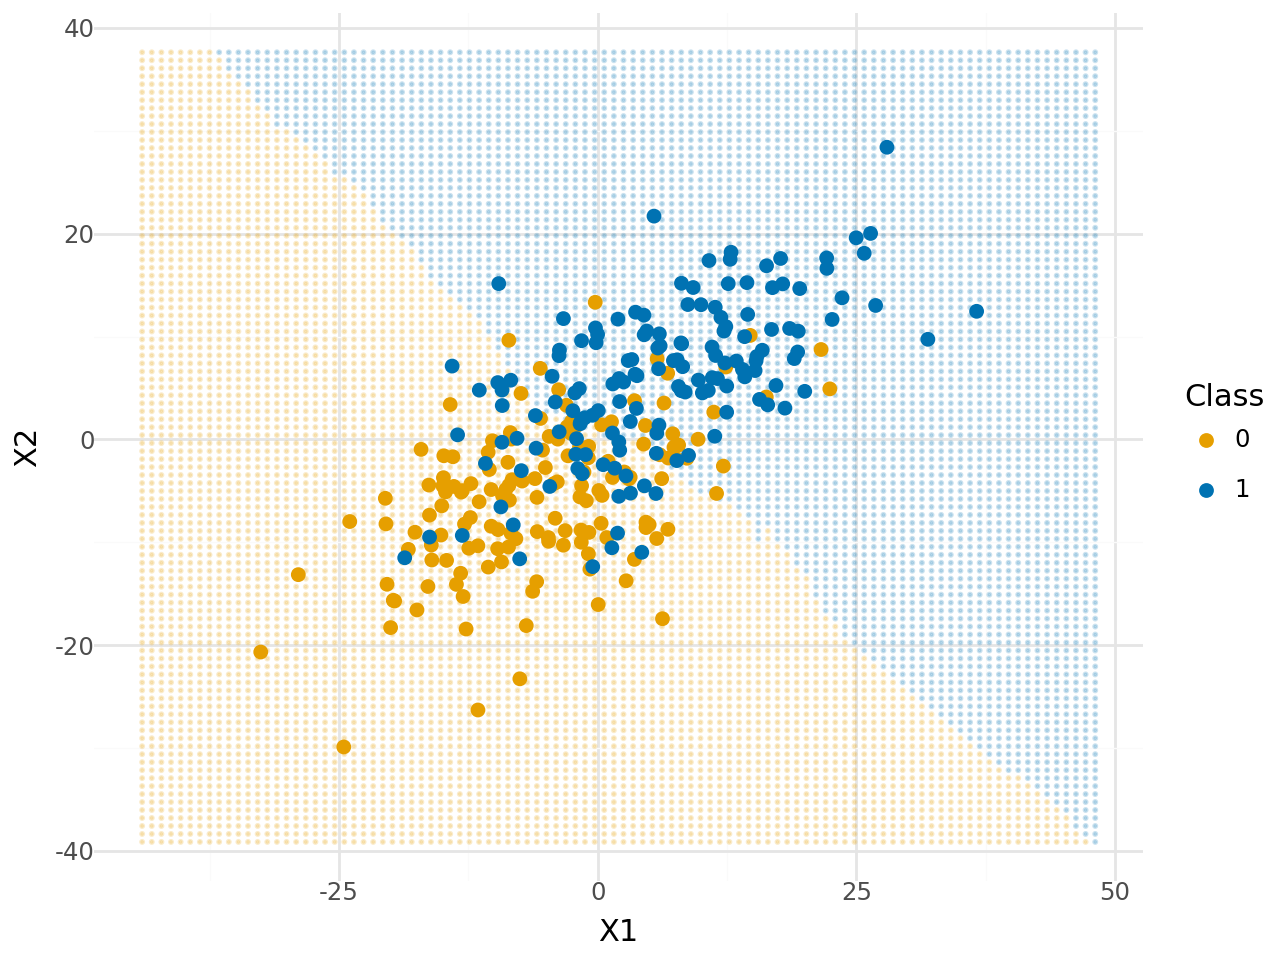

In [14]:
### YOUR CODE HERE ###

# k = 1
plotKNN2D(dd[["X1", "X2"]],dd["y"],1)

# k = 3
plotKNN2D(dd[["X1", "X2"]],dd["y"],3)

# k = 5
plotKNN2D(dd[["X1", "X2"]],dd["y"],5)

# k = 20
plotKNN2D(dd[["X1", "X2"]],dd["y"],20)

# k = 50
plotKNN2D(dd[["X1", "X2"]],dd["y"],50)

# k = 100
plotKNN2D(dd[["X1", "X2"]],dd["y"],100)

##  How does changing k affect the decision boundary (imbalanced classes)?

Now let's see how changing k affects the boundary when the groups have different numbers of samples. Using the `plotKNN2d()` function, and the data loaded below (`dd2`), examine what happens to the decision boundaries as you try different k's (try 1,3,5,10, 25, 50, and **100**).

**How does changing k affect the decision boundary when the groups are imbalanced?**
- As k increases, the decision boundary starts to favor the majority class, since the larger group dominates the neighborhood votes. This causes the boundary to shift toward the minority class, making it harder for those points to be correctly classified.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

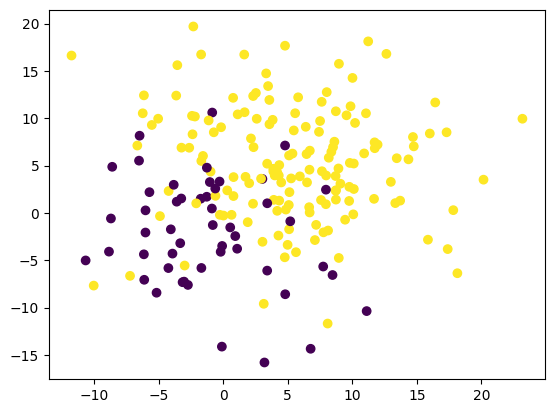

In [15]:
dd2 = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/knnclasswork2.csv")
dd2.head()
### MAKE A SCATTER PLOT OF THE DATA ###
plt.scatter(dd2["X1"], dd2["X2"], c = dd2["y"])


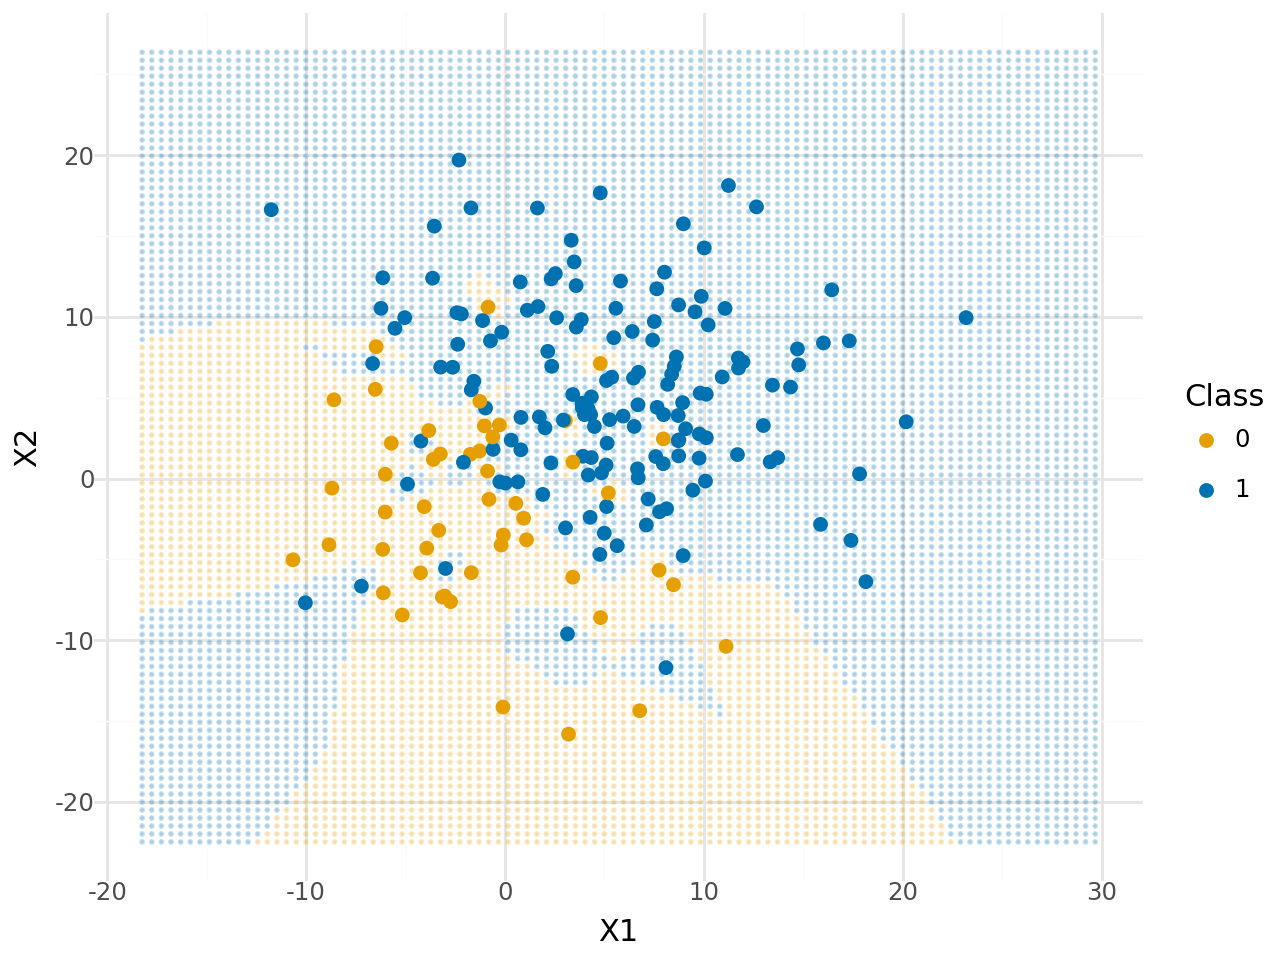

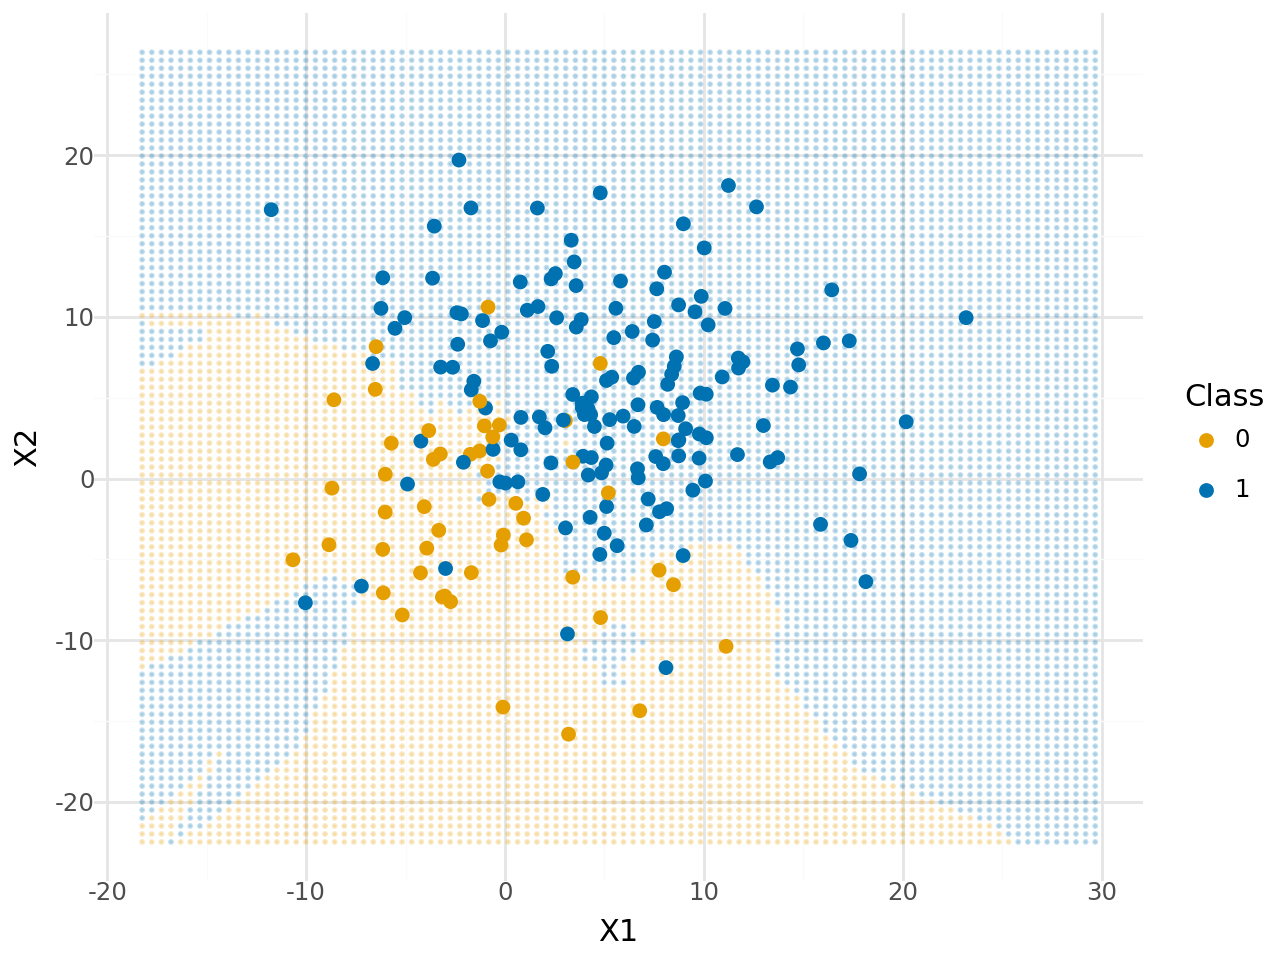

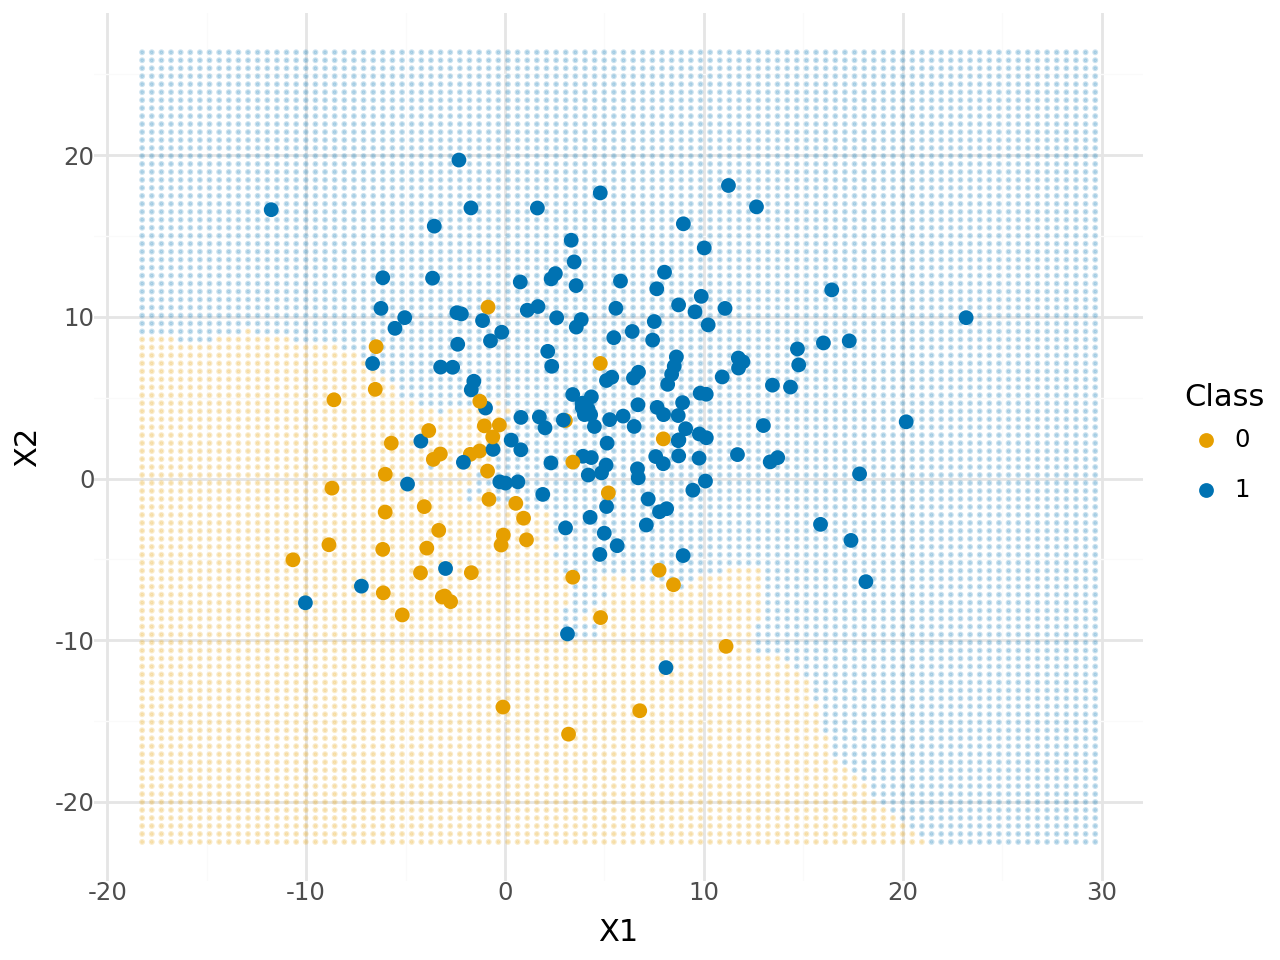

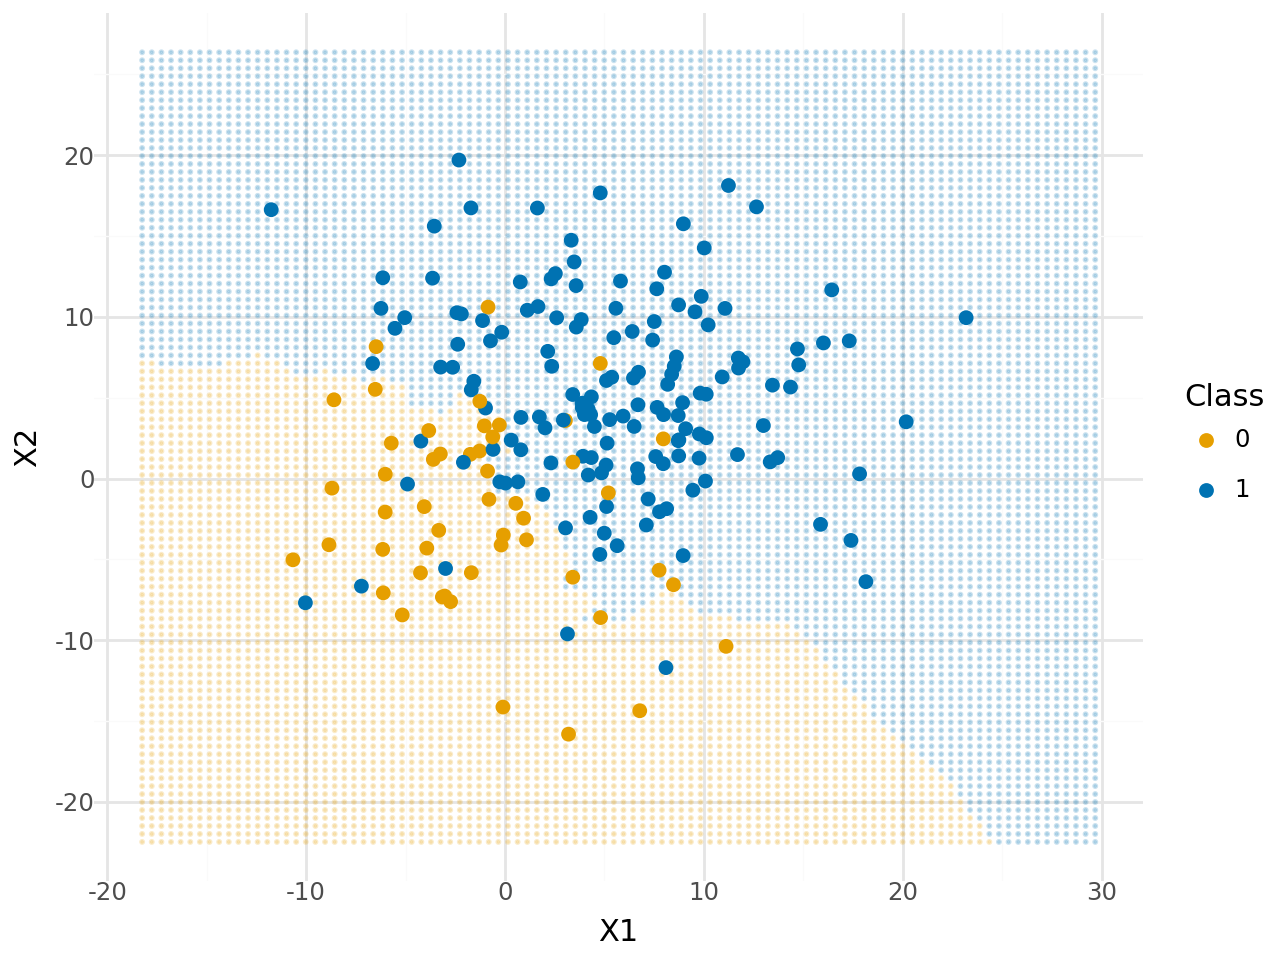

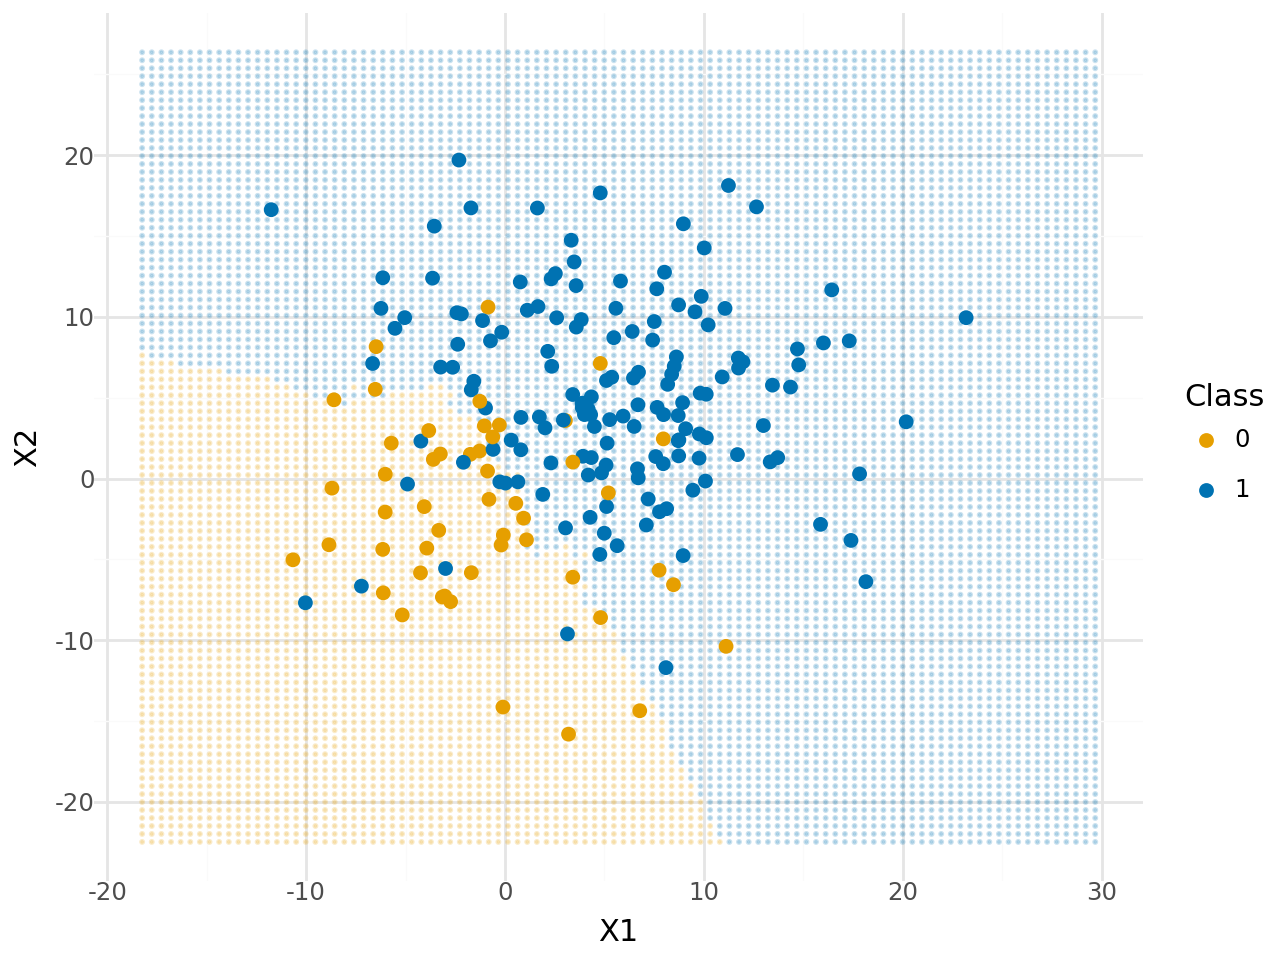

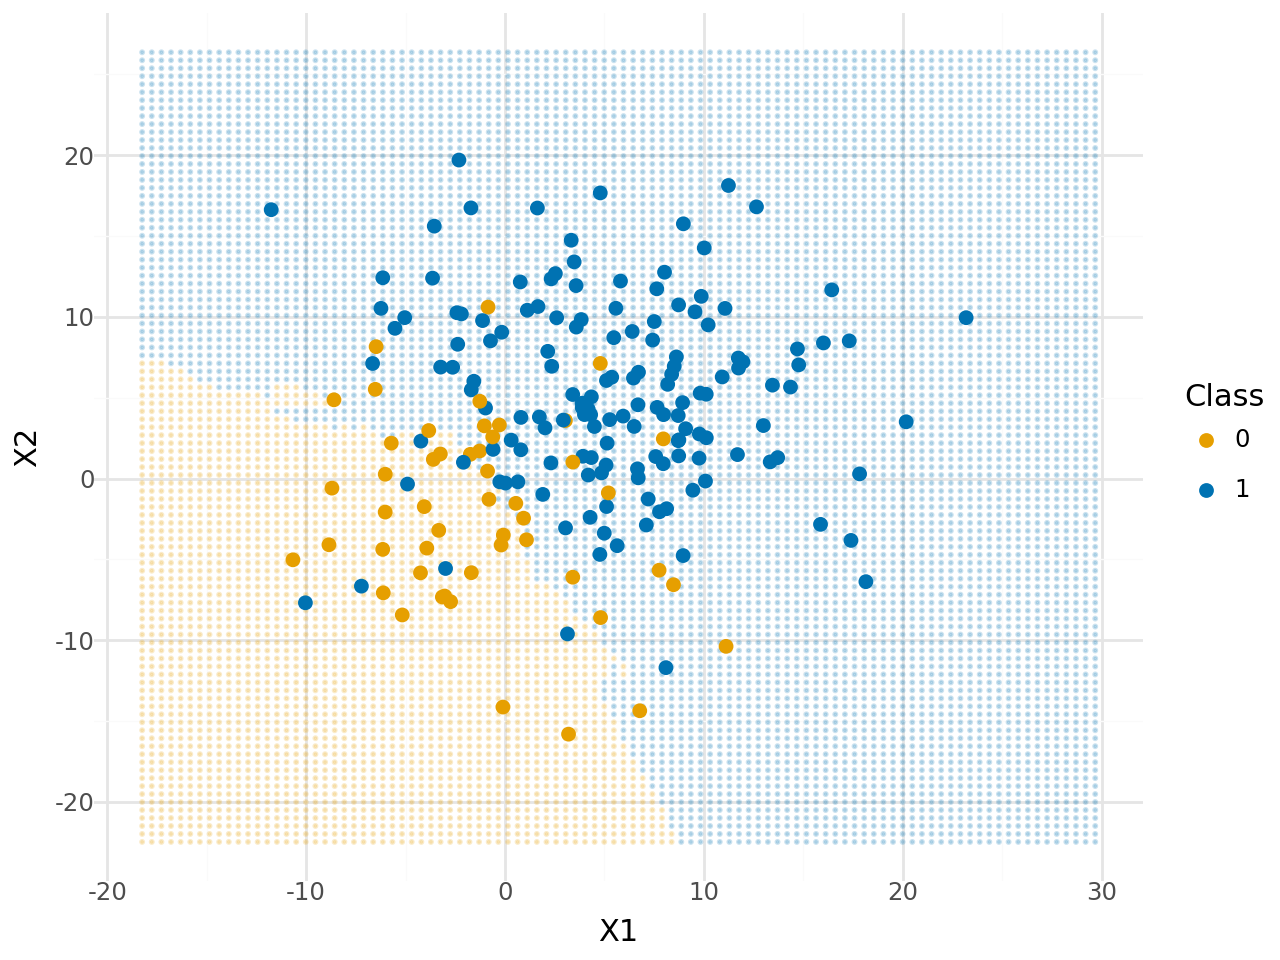

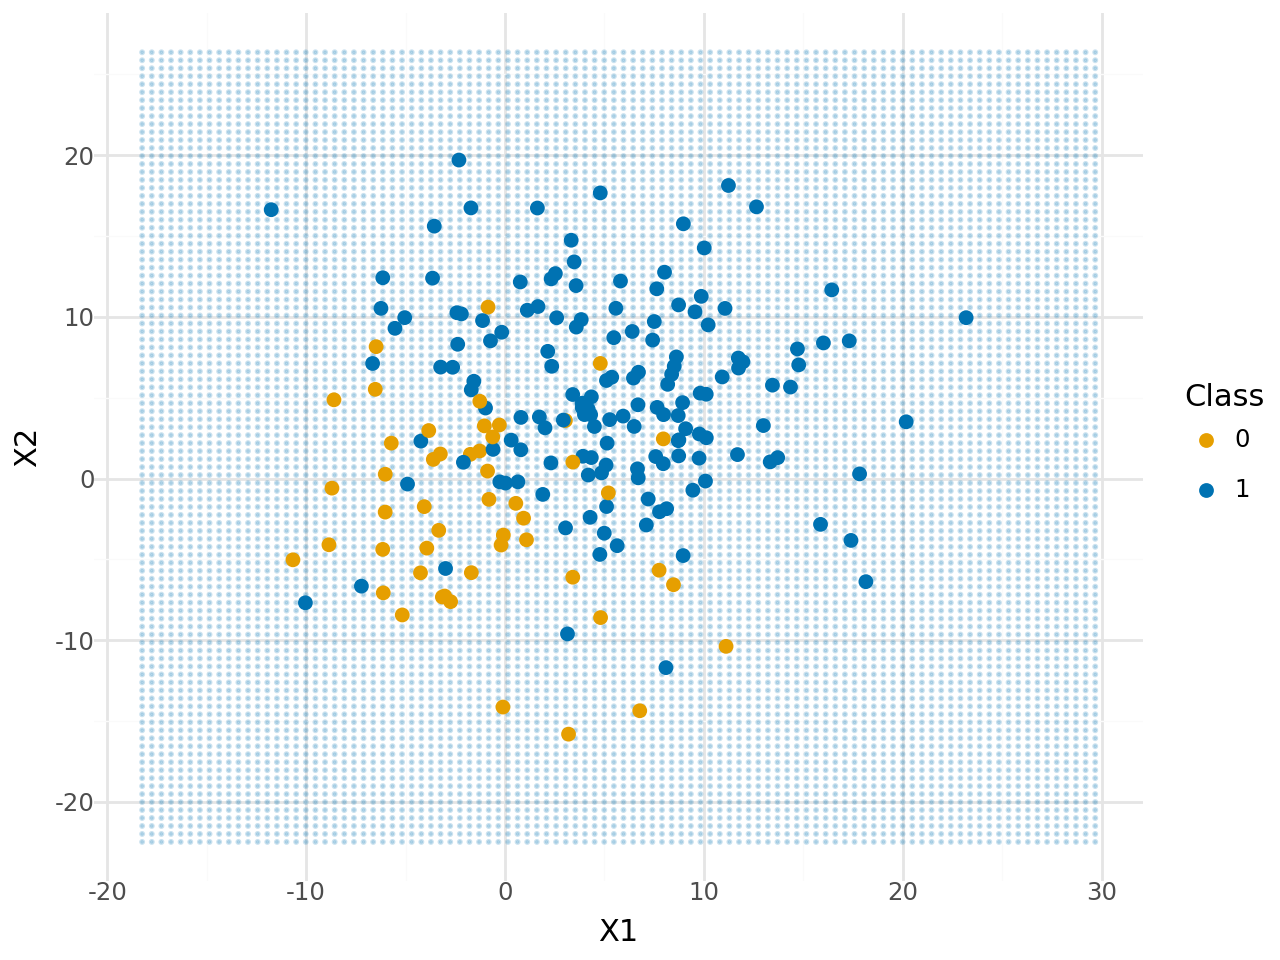

In [16]:
### YOUR CODE HERE ###

# k = 1
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],1)

# k = 3
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],3)

# k = 5
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],5)

# k = 10
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],10)

# k = 20
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],20)

# k = 50
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],50)

# k = 100
plotKNN2D(dd2[["X1", "X2"]],dd2["y"],100)

# `KNearestNeighbors()` and `GaussianNB()`

Use data:https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/wine-quality-white-and-red.csv, and use both KNN and Gaussian Naive Bayes to predict `type` (red vs. white) in this dataset (your predictors should be ALL variables except `type` and `quality`). Use 80/20 TTS, z score your continuous interval variables, and use `GridSearchCV()` to choose `n_neighbors` in your KNN Model.


### Question

How well did your models do?

- Both models performed very well, but KNN did slightly better across all metrics. The KNN model with k = 1 had an accuracy of about 99.38 percent, with high precision, recall, and F1 scores. This means it was able to correctly classify almost all red and white wines. Naive Bayes also had strong results with around 97 percent accuracy, and its precision and recall were both close to 94 percent. Overall, both models were effective, but KNN had more consistent and slightly higher performance.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = “200”/>


In [17]:
### YOUR CODE HERE ###
# Load data
wine = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/wine-quality-white-and-red.csv")

# Drop quality and set predictors
X = wine.drop(columns=["type", "quality"])
y = wine["type"]  # red vs white

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create scaler for all predictors
z = make_column_transformer((StandardScaler(), X.columns), remainder="passthrough")

# --------------------------
# KNEARESTNEIGHBORS
# --------------------------

# Build KNN pipeline
knn_pipe = Pipeline([
    ("z", z),
    ("model", KNeighborsClassifier())
])

# GridSearchCV to choose best k
k_values = {"model__n_neighbors": [1, 3, 5, 10, 15, 20]}
grid_knn = GridSearchCV(knn_pipe, k_values, scoring="accuracy", cv=5)
grid_knn.fit(X_train, y_train)

print("Best k:", grid_knn.best_estimator_.get_params()["model__n_neighbors"])

# Predict
y_pred_knn = grid_knn.predict(X_test)

# Evaluate
print("\nKNN Test Accuracy     :", accuracy_score(y_test, y_pred_knn))
print("KNN Test Precision    :", precision_score(y_test, y_pred_knn, pos_label='red'))
print("KNN Test Recall       :", recall_score(y_test, y_pred_knn, pos_label='red'))
print("KNN Test F1           :", f1_score(y_test, y_pred_knn, pos_label='red'))

Best k: 1

KNN Test Accuracy     : 0.9938461538461538
KNN Test Precision    : 0.9935483870967742
KNN Test Recall       : 0.9808917197452229
KNN Test F1           : 0.9871794871794872


In [18]:
### YOUR CODE HERE ###

# --------------------------
# GAUSSIANNB
# --------------------------

# Build NB pipeline
nb_pipe = Pipeline([
    ("z", z),
    ("model", GaussianNB())
])

# Fit
nb_pipe.fit(X_train, y_train)

# Predict
y_pred_nb = nb_pipe.predict(X_test)

# Evaluate
print("\nNB Test Accuracy      :", accuracy_score(y_test, y_pred_nb))
print("NB Test Precision     :", precision_score(y_test, y_pred_nb, pos_label='red'))
print("NB Test Recall        :", recall_score(y_test, y_pred_nb, pos_label='red'))
print("NB Test F1            :", f1_score(y_test, y_pred_nb, pos_label='red'))


NB Test Accuracy      : 0.9707692307692307
NB Test Precision     : 0.9367088607594937
NB Test Recall        : 0.9426751592356688
NB Test F1            : 0.9396825396825397


## Recommendation Systems

"If you like _________________ you should listen to ___________________ by Taylor Swift."

We're going to build a **Recommendation System** to recommend Taylor Swift songs for people by letting users select a song, and then recommending the most similar songs (according to `danceability`, `energy`, `instrumentalness`, `valence`, `loudness`, `liveness`, `speechiness`, `acousticness`).

To do this, we're going to load in our [training data](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/TaylorSwiftSpotify.csv), fit a `NearestNeighbors()` model, and then for each song in our [new data](https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KNNCompareSpotify.csv) we'll find the 10 most similar songs and recommend them!



In [12]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer


%matplotlib inline
training_data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/TaylorSwiftSpotify.csv")
new_data = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KNNCompareSpotify.csv")

feat = ["danceability", "energy", "instrumentalness", "valence", "loudness", "liveness", "speechiness", "acousticness"]


# Build Empty
z = make_column_transformer((StandardScaler(), feat))
nn = NearestNeighbors(n_neighbors= 10)
pipe = Pipeline([("z", z), ("model", nn)])
pipe.fit(training_data[feat])


# get distances, neighbors
# first grab model to make predictions, then use pre-processor to z score data
distances, neighbors = pipe.named_steps["model"].kneighbors(pipe.named_steps["z"].transform(new_data[feat]))

# add neighbors to data file
new_data = new_data.assign(neighbors = list(neighbors))
new_data.head()



artist_name               artist_id                album_id album_type  \
0  Selena Gomez  0C8ZW7ezQVs4URX5aX7Kqx  5obQ9rPASQW2mLxYM8Ko6Z      album   
1  Selena Gomez  0C8ZW7ezQVs4URX5aX7Kqx  5obQ9rPASQW2mLxYM8Ko6Z      album   
2  Selena Gomez  0C8ZW7ezQVs4URX5aX7Kqx  5obQ9rPASQW2mLxYM8Ko6Z      album   
3  Selena Gomez  0C8ZW7ezQVs4URX5aX7Kqx  5obQ9rPASQW2mLxYM8Ko6Z      album   
4  Selena Gomez  0C8ZW7ezQVs4URX5aX7Kqx  5obQ9rPASQW2mLxYM8Ko6Z      album   

  album_release_date  album_release_year album_release_date_precision  \
0         2020-04-09                2020                          day   
1         2020-04-09                2020                          day   
2         2020-04-09                2020                          day   
3         2020-04-09                2020                          day   
4         2020-04-09                2020                          day   

   danceability  energy  key  ...  track_preview_url  track_number   type  \
0         0.811   0.512    2  ...                NaN             1  track   
1         0.488   0.343    4  ...                NaN             2  track   
2         0.838   0.545    5  ...                NaN             3  track   
3         0.841   0.479    0  ...                NaN             4  track   
4         0.753   0.564   10  ...                NaN             5  track   

                              track_uri  \
0  spotify:track:5EBtY2shIV1vmY4bnvvV6T   
1  spotify:track:3RKywhObU25JLEypRY6HWx   
2  spotify:track:33iba4j2ywXqTQNEpGbfra   
3  spotify:track:3ZCBSFcZSRM9Z48ew28Zrf   
4  spotify:track:4sUWh0WAFyla5vjEYRrIGz   

                               external_urls.spotify     album_name  key_name  \
0  https://open.spotify.com/track/5EBtY2shIV1vmY4...  Rare (Deluxe)         D   
1  https://open.spotify.com/track/3RKywhObU25JLEy...  Rare (Deluxe)         E   
2  https://open.spotify.com/track/33iba4j2ywXqTQN...  Rare (Deluxe)         F   
3  https://open.spotify.com/track/3ZCBSFcZSRM9Z48...  Rare (Deluxe)         C   
4  https://open.spotify.com/track/4sUWh0WAFyla5vj...  Rare (Deluxe)        A#   

   mode_name  key_mode                                          neighbors  
0      major   D major    [177, 172, 175, 39, 28, 196, 236, 157, 166, 30]  
1      major   E major    [213, 140, 12, 216, 41, 273, 122, 90, 226, 107]  
2      major   F major  [250, 155, 249, 78, 223, 165, 196, 230, 175, 214]  
3      minor   C minor  [250, 157, 166, 196, 177, 249, 155, 214, 236, ...  
4      minor  A# minor    [177, 39, 175, 180, 235, 170, 28, 172, 37, 158]  

[5 rows x 37 columns]

In [13]:
## you will find the indexes of the 10 songs will be stored in "neighbors" column.
### input the index of the song you'd like to listen, then you can get the 10 recommended songs
recommend=new_data.loc[1,"neighbors"]
training_data.iloc[recommend]

artist_name               artist_id                album_id album_type  \
213  Taylor Swift  06HL4z0CvFAxyc27GXpf02  1MPAXuTVL2Ej5x0JHiSPq8      album   
140  Taylor Swift  06HL4z0CvFAxyc27GXpf02  0PZ7lAru5FDFHuirTkWe9Z      album   
12   Taylor Swift  06HL4z0CvFAxyc27GXpf02  5AEDGbliTTfjOB8TSm1sxt      album   
216  Taylor Swift  06HL4z0CvFAxyc27GXpf02  1MPAXuTVL2Ej5x0JHiSPq8      album   
41   Taylor Swift  06HL4z0CvFAxyc27GXpf02  1fnJ7k0bllNfL1kVdNVW1A      album   
273  Taylor Swift  06HL4z0CvFAxyc27GXpf02  5EpMjweRD573ASl7uNiHym      album   
122  Taylor Swift  06HL4z0CvFAxyc27GXpf02  0PZ7lAru5FDFHuirTkWe9Z      album   
90   Taylor Swift  06HL4z0CvFAxyc27GXpf02  4hDok0OAJd57SGIT8xuWJH      album   
226  Taylor Swift  06HL4z0CvFAxyc27GXpf02  1MPAXuTVL2Ej5x0JHiSPq8      album   
107  Taylor Swift  06HL4z0CvFAxyc27GXpf02  6AORtDjduMM3bupSWzbTSG      album   

    album_release_date  album_release_year album_release_date_precision  \
213         2017-11-09                2017                          day   
140         2020-11-25                2020                          day   
12          2023-07-07                2023                          day   
216         2017-11-09                2017                          day   
41          2023-05-26                2023                          day   
273         2010-10-25                2010                          day   
122         2020-11-25                2020                          day   
90          2021-04-09                2021                          day   
226         2017-11-09                2017                          day   
107         2021-01-07                2021                          day   

     danceability  energy  key  ...  \
213         0.481   0.435    4  ...   
140         0.509   0.386    2  ...   
12          0.550   0.366   10  ...   
216         0.442   0.480    1  ...   
41          0.475   0.386    0  ...   
273         0.371   0.341   10  ...   
122         0.456   0.265    0  ...   
90          0.546   0.273    9  ...   
226         0.578   0.348    0  ...   
107         0.559   0.334   11  ...   

                                            track_name  track_preview_url  \
213                                          This Love                NaN   
140         mirrorball - the long pond studio sessions                NaN   
12                        Last Kiss (Taylor's Version)                NaN   
216                                            Breathe                NaN   
41                                         Dear Reader                NaN   
273                                          Last Kiss                NaN   
122                                  my tears ricochet                NaN   
90   Forever & Always (Piano Version) (Taylor’s Ver...                NaN   
226                                        White Horse                NaN   
107                                          happiness                NaN   

     track_number   type                             track_uri  \
213            30  track  spotify:track:64KRxmbqypPBlya4nxFmDn   
140             6  track  spotify:track:2yceD2hx5HhOLgkm1CITCi   
12             13  track  spotify:track:59KOoHFcw5XfICnO57holu   
216            33  track  spotify:track:3oxgFdIlxFEDEJqn7k5TVN   
41             20  track  spotify:track:10GRRCR5fctuOF4GFmATJI   
273            13  track  spotify:track:1D27z8xNzjW0Mwwt1NCWhJ   
122             5  track  spotify:track:0Oju1YcbPCJuUQQWoZNdJK   
90             16  track  spotify:track:01QdEx6kFr78ZejhQtWR5m   
226            43  track  spotify:track:4RMfSYDFkcz0bKoK8fHDgR   
107             7  track  spotify:track:55Vf4bimc1Rtfg0PAQRAo2   

                                 external_urls.spotify  \
213  https://open.spotify.com/track/64KRxmbqypPBlya...   
140  https://open.spotify.com/track/2yceD2hx5HhOLgk...   
12   https://open.spotify.com/track/59KOoHFcw5XfICn...   
216  https://open.spotify.com/track/3oxgFdIlxFEDEJq...   
41  